<a href="https://colab.research.google.com/github/MrtnMndt/mlpr19/blob/master/week4/k_means_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# k-means and PCA
In this week we will code k-means - a quite simple clustering algorithm, which, given the amount of clusters, finds their means and assigns the data points to their respective clusters. Then, we will choose a cluster and perform PCA on it.

**Create 3D Gaussian clusters**

First, let us create our data ourselves. This way, we can thed adjust the clusters and see how the performance of our algorith changes.

In [2]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [18]:
A = np.random.randn(2,10)
B = np.array([1,10])
A.T+B

array([[-0.42497936, 11.36711459],
       [-0.1449811 , 10.1582382 ],
       [ 1.19091157,  8.67158731],
       [-0.60123919, 10.65848201],
       [-0.09482325, 10.56486053],
       [ 1.68941928, 10.93013027],
       [ 0.87427156, 10.05810126],
       [ 0.09381268, 10.09613934],
       [ 0.88839805,  9.46738913],
       [ 1.0264505 ,  9.58630186]])

Let us write a function which will create our clusters.

In [25]:
def create_gaussian_data(k,means_per_cluster, covariances_per_cluster, n_per_cluster):
    '''
    Creates k clusters, each of which is sampled from a 3d Gaussian with given means, covariance matrices
    and number of elements per cluster.
    For 3d Gaussian elements, each mean would also be 2d, and the covariance matrix would have dimensions 3x3.
    Returns a list of created points, so (n_points, dim_data)
    '''

    data = []
    for ki in range(k):
        # append a cluster to data for every ki
        normal = np.random.randn(n_per_cluster[ki], 3)
        normal = sqrtm(covariances_per_cluster[ki]) @ (normal+means_per_cluster[ki]).T
        data.append(normal)
    
    # our data will have dimensions (k, n_data, n_dim)
    data = np.array(data).reshape(-1, len(means_per_cluster[0]))
    return data

Let us define the variables needed to create the cluster and create some data.

In [32]:
n_clusters = 3
means = np.array([[0,0,0],[-5,-5,-5],[5,5,5]])
# covariance matrice must be symmetric and positive-semidefinite
# example 1: diagonal covariance
# 1 0 0
# 0 1 0
# 0 0 1

# example 2: covariance terms between first and second dimension are not zero
# 1   0.5   0
# 0.5  1    0
# 0    0    1

# think about what it means to have positive, negative and zero covariance terms
covariance_matrices = [[[1,0,0],
                        [0,1,0],
                        [0,0,1]],
                      [[10,0.,0],
                       [0.,1.,0],
                       [0,0,1]],
                      [[1,0,0.8],
                       [0,1,0.],
                       [0.8,0.,1]]]
n_per_cluster = [500,500,500]

data = create_gaussian_data(n_clusters, means, covariance_matrices, n_per_cluster)

In [33]:
# check the shape of your data: it should be sum(n_per_cluster) x data_dimension
data.shape

(1000, 3)

Let us visualize the data we created. The plotting works on the assumption that our data are 3d. Press play to see the animation.

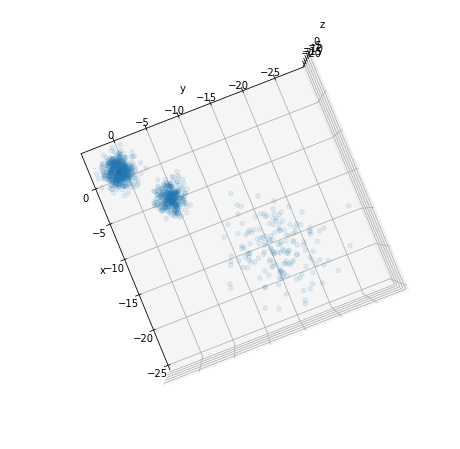

In [35]:
# https://de.wikipedia.org/wiki/Azimut
# animation is similar to https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2], alpha=0.1)
ax.scatter(means[:,0], means[:,1], means[:,2], c='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

elev = 5
azim = 70

def animate(i):
    global azim, elev
    azim+=5
    elev+=5
    
    ax.view_init(elev, azim)

ani = animation.FuncAnimation(fig, animate,
                              frames=15, interval=100, repeat_delay=100)

HTML(ani.to_jshtml())

Let us now implement** k-means** - a clustering algorithm, which will assign the  points of our 3 Gaussians to some cluster. Set the number of clusters to 3 for starters. Thus, the number of clusters for k means fits the number of actual clusters in the data:

https://www.cs.utah.edu/~jeffp/teaching/cs5955/L10-kmeans.pdf

In [36]:
# first, let us implement a squared euclidean distance function
def dist(x1,x2):
    '''
    Computes the squared euclidean distance: ||x - y||**2
    Args:
        x1 (array of length dim_data): first data point
        x2 (array of length dim_data): second data point
    Returns:
        Float value of the squared euclidean distance (it is squared to save computation time)
    '''
    # return np.square(np.linalg.norm(x1-x2))
    return np.linalg.norm(x1-x2)

In [81]:
def kmeans(k, data, distance_func):
    '''
    Lloyd algorithm for kmeans.
    Args:
        k: number of clusters
        data: list/array of data points
        distance_func: the distance function to measure distances between points
    Returns:
        Array of cluster centers, 
        Array of cluster assignments of datapoints
    '''
    
    # 1. choose k random points from the dataset as initial cluster centers
    # 1a. create k random indices in range between 0 and the length of your dataset
    center_indices = np.random.randint(0,len(data),k)
    # 1b. select the points according to the chosen indices
    means = data[center_indices]
    
    # create an array with zeros of the same length as dataset to save the cluster assignments
    cluster_assignments = np.zeros(len(data))
    
    # as long as the centers change, repeat: 2. assign points to their closest means, 3. recompute means
    # to assure that the algorithm terminates, restrict also the maximum number of iterations
    max_iterations = 100
    # choose an epsilon to compare later whether the means of the new iteration change
    # in comparison to the previous iteration
    epsilon = 1e-5
    
    for it in range(max_iterations):
        
        # iterate through all data points
        for d_ind, d in enumerate(data):
            cluster_index = -1
            best_distance = np.inf
            
            # iterate through all means, choose the closest mean
            for cl_ind, m in enumerate(means):
                _dist = dist(d, m)
                if _dist < best_distance:
                    best_distance = _dist
                    cluster_index = cl_ind
                
            
            # assign the best cluster to the data point
            cluster_assignments[d_ind] = cluster_index
            
        # recompute means (cluster centers)
        change = False
        for ki in range(k):
            # create a mask which is true when the point has been assigned to the ki-th cluster
            mask = (cluster_assignments == ki)
            #mask.dtype = np.boolean
            # select points which belong to the ki-th cluster
            data_ki = data[mask]
            
            # compute the new cluster mean as the average over the data points
            # hint: mean over which axis?
            mean_tmp = np.mean(data_ki, axis=0)
            
            # check if the new mean is different from the old one
            # if yes - set change to True
            # hint: use epsilon
            if dist(mean_tmp, means[ki]) > epsilon:
                change = True
            else:
                change = False
            
            # update the saved cluster mean
            means[ki] = mean_tmp
        
        # print the means of the current iteration
        print(it, means)
        
        # stop the iterations, if means did not change
        if not change:
            break
            
    return means, cluster_assignments

In [82]:
cluster_means, cluster_assignments = kmeans(3,data,dist)

0 [[-0.05717387 -0.32615855  0.73572391]
 [-8.64613023 -8.60818509 -8.60748788]
 [ 0.20731474  0.15144403 -0.77105407]]
1 [[-0.09129933 -0.39083268  0.7226597 ]
 [-8.97122265 -8.93355595 -8.9185918 ]
 [-0.2407842  -0.2636714  -1.1269911 ]]
2 [[ 0.15789573 -0.14833866  0.64091017]
 [-9.64979175 -9.58634962 -9.56740155]
 [-1.30259834 -1.3023082  -1.98802821]]
3 [[  0.22580669   0.0177069    0.18792307]
 [-13.16326646 -13.11909469 -13.02557921]
 [ -3.88639257  -3.83832045  -4.06178199]]
4 [[  0.08088918  -0.07685     -0.0508142 ]
 [-15.7690421  -15.86336733 -15.60344956]
 [ -5.07397924  -4.9697003   -5.0990026 ]]
5 [[  0.08088918  -0.07685     -0.0508142 ]
 [-15.75867461 -15.91101227 -15.66556951]
 [ -5.11115309  -4.97863625  -5.09957905]]
6 [[  0.08088918  -0.07685     -0.0508142 ]
 [-15.75867461 -15.91101227 -15.66556951]
 [ -5.11115309  -4.97863625  -5.09957905]]


In [83]:
# plot your data, the ground truth means and the predicted cluster means
# use cluster_assignments for color assignments 
# (to see which points have been assigned to which clusters)
def plot_kmeans_results(data, means, cluster_means, cluster_assignments):

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')

    # if you do not see the points well enough, tweak alpha
    ax.scatter(data[:,0], data[:,1], data[:,2], c = cluster_assignments, alpha=0.05)
    # show calculated means
    ax.scatter(cluster_means[:,0], cluster_means[:,1], cluster_means[:,2], c='red')
    # show ground truth means (from which the data where generated)
    ax.scatter(means[:,0], means[:,1], means[:,2], c='black', marker='s')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(5, 73)

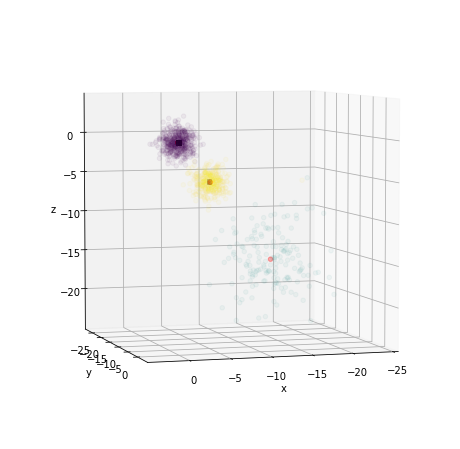

In [84]:
plot_kmeans_results(data, means, cluster_means, cluster_assignments)

In order to better understand the algorithm, please do the following tests:

1. Change the number of clusters when running kmeans on your data from 3 to 2, 5 and 10. What happens?
2. Regenerate your data with closer means and rerun kmeans with different k. What do you observe?

Optional:
3. Regenerate your data with a higher number of overlapping clusters. Rerun kmeans with different k.

In [0]:
# 1. Tweak the number of kmeans clusters and run kmeans on your data
//TODO

In [0]:
# visualize the clusters
# hint: we have a defined a function for that
//TODO

In [0]:
# 2. Regenerate data: tweak the means and/or covariances

//TODO

In [0]:
# run kmeans on your new data
//TODO

In [0]:
# plot the new results
//TODO

# PCA - Principal Component Analysis

Let us now proceede by choosing one cluster from our 3 initial clusters and computing the **principal components** or the directions of maximal variance of the data. Principal components are the **eigenvectors** of the covariance matrix for your data.
An easy description of how to do PCA can be found at https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c , http://www.iro.umontreal.ca/~pift6080/H09/documents/papers/pca_tutorial.pdf

First, let us regenerate the original cluster data (where clusters were easily separable).

In [0]:
n_clusters = 3
means = np.array([[0,0,0],[-5,-5,-5],[5,5,5.]])

covariance_matrices = [[[1,0,0],
                        [0,1,0],
                        [0,0,1]],
                      [[10,0.,0],
                       [0.,1.,0],
                       [0,0,1]],
                      [[1,0,0.8],
                       [0,1,0.],
                       [0.8,0.,1]]]
n_per_cluster = [500,500,500]

data = create_gaussian_data(n_clusters, means, covariance_matrices, n_per_cluster)
cluster_means, cluster_assignments = kmeans(3,data,squared_euclid_distance)
plot_kmeans_results(data, means, cluster_means, cluster_assignments)

1. Let us now standardize our data: we subtract the respective mean from each of our data dimensions and divide by the standard deviation. We do it so that one feature does not dominate over the others. Data dimensions are features in our case. Sklearn also offers these functions:
https://scikit-learn.org/stable/modules/preprocessing.html , but if possible - just use numpy.

    Important: preprocessing the data so that they have zero mean and unit variance is not the same as preprocessing them into a certain range, e.g. so that all values are between 0 and 1 (!)

    **Normalization**: rescale to 0-1 range.

    **Standardization**: zero mean unit variance (subtract the mean and divide by the standard deviation).

In [0]:
# # let us look at our current data mean and std of the cluster with mean (5,5,5)
# because there the xz-covariance was not zero
# for that, print the computed means to get the index of the cluster to choose
print(cluster_means)

[[-7.02456889e-04  3.28885031e-02 -3.60397318e-02]
 [ 5.00949832e+00  4.96970475e+00  5.02766864e+00]
 [-5.18635294e+00 -5.03901128e+00 -5.01641772e+00]]


In [0]:
# choose a cluster index and get its cluster data points
ki = //TODO
cluster_data = //TODO

cluster_data_mean = //TODO
cluster_data_std = //TODO

print(cluster_data_mean)
print(cluster_data_std)

[5.00949832 4.96970475 5.02766864]
[0.99561488 1.03123814 1.02761336]


In [0]:
data_s = (cluster_data - cluster_data_mean.reshape(1,-1))/cluster_data_std.reshape(1,-1)

In [0]:
# check that the new data mean is close to zero
print(data_s.mean(axis=0))

[8.23509624e-16 6.77891778e-16 2.39003205e-15]


2.  Compute the covariance matrix.

In [0]:
# since we already subtracted the means from our data dimension and our mean is zero,
# the covariance can be computed as X.Transposed @ X/(n-1) where X is our data and n - number of data points

covar = //TODO

# covariance should be a (3 x 3) matrix, because we are in 3d
print(covar.shape)

(3, 3)


3. Compute the eigenvectors/values of the covariance matrix.

    https://math.mit.edu/~gs/linearalgebra/ila0601.pdf
    
    We will use numpy`s function for that: np.linalg.eig (https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html)

In [0]:
eigenvals, eigenvecs = //TODO

In [0]:
print('eigenvalues:')
print(eigenvals)
print('eigenvectors')
print(eigenvecs)

In [0]:
# check that the vectors are really orthogonal

print(np.dot(eigenvecs[:,0],eigenvecs[:,1]))
print(np.dot(eigenvecs[:,0],eigenvecs[:,2]))
print(np.dot(eigenvecs[:,1],eigenvecs[:,2]))

-5.551115123125783e-16
-1.1796119636642288e-16
0.0


In [0]:
# let us scale the unit eigenvectors by the amount of variance they explain
# to visually better recognize them during plotting
scaled_eigenvecs = eigenvecs * 3*np.sqrt(eigenvals.reshape(1,-1))

Let us look at what has been computed. Note that the eigenvalues are not necessarily ordered.

In [0]:
def visualize_principal_components(data, eigenvecs, azim, elev):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(data[:,0], data[:,1], data[:,2], alpha=0.1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(elev, azim)
    
    # setting equal limits helps better compare how the data spread for different dimensions
    
    min_lim = data.max()
    max_lim = data.min()
    ax.set_xlim(min_lim,max_lim)
    ax.set_ylim(min_lim,max_lim)
    ax.set_zlim(min_lim,max_lim)
    
    mean = data.mean(axis=0)
    
    for i in range(3):    
        ax.plot([mean[0],eigenvecs[0,i]],
                [mean[1],eigenvecs[1,i]],
                [mean[2],eigenvecs[2,i]])
    return fig, ax

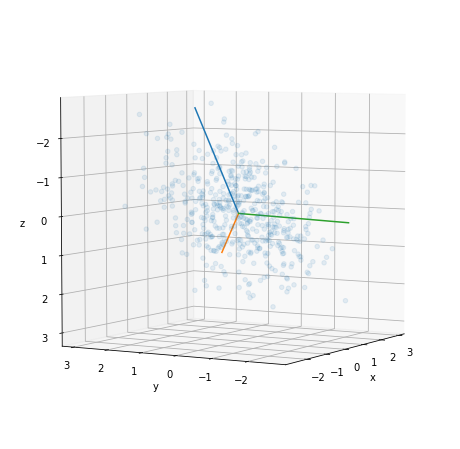

In [0]:
elev = 5
azim = 70

# visualize the standardized data with the scaled eigenvectors
fig, ax = visualize_principal_components(data_s, 
                                         scaled_eigenvecs,
                                         azim, elev)

def animate(i):
    global azim, elev, ax
    azim+=10
    
    ax.view_init(elev, azim)

ani = animation.FuncAnimation(fig, animate,
                             frames=30, interval=500)

HTML(ani.to_jshtml())

4. Sort in descending order the **eigenvectors** according to its corresponding **eigenvalues**.

In [0]:
sort_indices = np.argsort(eigenvals)
sorted_eigenvals = eigenvals[sort_indices][::-1]
# transpose the eigenvectors, such that they are rows, sort, 
# then transpose them back to columns
sorted_eigenvecs = eigenvecs.T[sort_indices][::-1].T

print(eigenvals)
# the order of eigenvectors has changed
print('before')
print(eigenvecs)
print('after')
print(sorted_eigenvecs)

[1.81865497 0.19298431 0.99437275]
before
[[-0.70176351 -0.7049952   0.10251706]
 [-0.10425979 -0.04071962 -0.99371616]
 [-0.70473958  0.70804214  0.04492711]]
after
[[-0.70176351  0.10251706 -0.7049952 ]
 [-0.10425979 -0.99371616 -0.04071962]
 [-0.70473958  0.04492711  0.70804214]]


<BarContainer object of 3 artists>

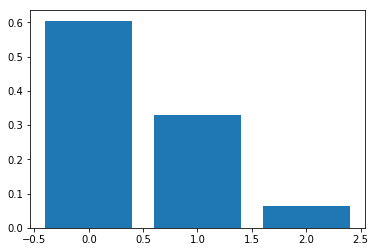

In [0]:
# check how much of the variance is explained by the components

plt.bar(x=range(len(sorted_eigenvals)),height=sorted_eigenvals/np.sum(sorted_eigenvals))

In [0]:
# transform the data to fit the basis

trafo_cluster = //TODO
# if we treat sorted eigenvectors as data points (transpose them for that)
# and perform the basis transformation, then we get the identity matrix
trafo_eigenvecs = sorted_eigenvecs.T @ sorted_eigenvecs
print(trafo_eigenvecs)
trafo_eigenvecs = trafo_eigenvecs * 3*np.sqrt(sorted_eigenvals.reshape(1,-1))

[[ 1.00000000e+00 -1.17961196e-16 -5.55111512e-16]
 [-1.17961196e-16  1.00000000e+00  0.00000000e+00]
 [-5.55111512e-16  0.00000000e+00  1.00000000e+00]]


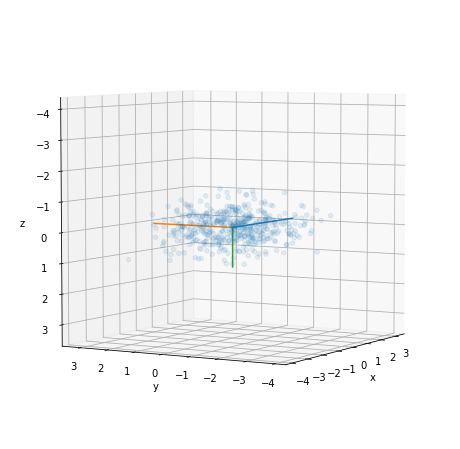

In [0]:
elev = 5
azim = 70

fig, ax = visualize_principal_components(trafo_cluster, trafo_eigenvecs, azim, elev)

# setting equal limits helps better compare how the data spread for different dimensions
# since we know that after PCA the greatest variance axis is the first, 
# we use it for setting axis visualization limits

def animate(i):
    global azim, elev, ax
    azim+=10
    
    ax.view_init(elev, azim)

ani = animation.FuncAnimation(fig, animate,
                             frames=30, interval=500)

HTML(ani.to_jshtml())